In [53]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, recall_score
from torch.cuda.amp import autocast, GradScaler

# **Datapreprocessing.py**


In [127]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
# 데이터프레임 합치기 (concatenate)
train_data = pd.read_csv("/content/drive/MyDrive/train_seoul.csv")
test_data=pd.read_csv("/content/drive/MyDrive/test_seoul.csv")
print(train_data)
print(test_data)

       관측온도  관측습도    관측기압  관측풍속   관측풍향    관측최대풍속  관측극초미세먼지  배관관측온도  \
0       1.9  91.0  1026.1   0.9  328.8  1.600000      37.6     0.4   
1       1.0  88.9  1020.1   0.2   14.4  0.600000      37.3     0.4   
2       0.9  91.3  1017.6   0.8    4.2  2.000000      33.8     0.2   
3      -0.9  93.5  1026.2   0.0    0.0  1.225843      46.0     0.1   
4       1.5  85.1  1024.7   0.0    0.0  0.500000      48.1     0.4   
...     ...   ...     ...   ...    ...       ...       ...     ...   
68560  10.2  63.2  1020.7   0.5  104.7  1.600000       3.1     0.4   
68561   9.7  73.8  1016.9   0.4  179.3  1.100000      16.6     0.4   
68562   9.3  74.5  1008.4   0.4   75.6  1.400000      18.2     0.3   
68563   8.9  74.0  1002.8   0.3  282.8  0.600000      16.3     0.4   
68564  10.0  62.0  1022.2   0.7  276.0  1.500000       7.8     0.4   

       (AVOC)관측온도  (AVOC)관측습도  ...  (BVOC)관측풍속  (BVOC)관측풍향  (BVOC)관측최대풍속  \
0             2.0        91.3  ...         0.5       344.0      1.600000   
1      

In [75]:
# 특성과 타겟 변수 분리
X_train = train_data.drop(columns=["관측미세먼지"]).values
X_test = test_data.drop(columns=["관측미세먼지"]).values
y_train = train_data["관측미세먼지"].values
y_test = test_data["관측미세먼지"].values

# 각각 train과 test를 알맞게 데이터와 매치, 관측 지점과 관측시간은 숫자형이 아니라서 일단 배제, 추후 필요 없는 특성이면 drop, 아니라면 다른 전처리 필요
X_train = train_data.drop(columns=["관측미세먼지", "경과일","경과시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
X_test = test_data.drop(columns=["관측미세먼지","경과일","경과시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
y_train = train_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values
y_test = test_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values

# 스탠다드 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Tensor로 변환 및 차원 변경
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)  # (batch_size, seq_len=1, input_dim)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# DataLoader 정의
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [76]:
print(f"X_train shape: {X_train.shape}")  # 데이터 형태 확인
print(f"X_test shape: {X_test.shape}")  # 데이터 형태 확인
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"train_loader shape: {train_loader.batch_size}")
print(f"Example batch shape from DataLoader: {next(iter(train_loader))[0].shape}")  # 배치 데이터 형태 확인

X_train shape: torch.Size([68565, 1, 28])
X_test shape: torch.Size([24467, 1, 28])
y_train shape: torch.Size([68565, 1])
y_test shape: torch.Size([24467, 1])
train_loader shape: 32
Example batch shape from DataLoader: torch.Size([32, 1, 28])


In [77]:
# CPU 혹은 GPU 사용, GPU 우선적으로 사용 가능
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#**LSTM.py**

In [11]:
import torch
from sklearn.model_selection import ParameterGrid
import torch.optim as optim

def grid_search(model_cls, train_data, train_label, dataloader, param_grid, device, num_epochs=10):
    results = []
    param_list = list(ParameterGrid(param_grid))

    for params in param_list:
        print("Current Parameters:", params)
        model = model_cls(**{k: v for k, v in params.items() if k != 'lr'}).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader.dataset):.4f}")
            model.eval()
            test_loss = 0.0
            with torch.no_grad():
              outputs = model(train_data.to(device))
              mse = mean_squared_error(train_label.cpu().numpy(), outputs.squeeze().cpu().numpy())
              rmse = np.sqrt(mse)
              r2 = r2_score(train_label.cpu().numpy(), outputs.squeeze().cpu().numpy())
              sensitivity = recall_score((train_label.cpu().numpy() >= 81).astype(int), (outputs.squeeze().cpu().numpy() >= 81).astype(int))
            print(f"Sensitivity: {sensitivity:.4f}")
            results.append({'params': params, 'rmse': rmse, 'r2': r2, 'sensitivity': sensitivity})
            print(f"RMSE: {rmse}, R2: {r2}, Sensitivity: {sensitivity}")
            print("------------------------")

    # 민감도가 가장 높은 모델의 파라미터 선택
    best_result_sensitivity = max(results, key=lambda x: x['sensitivity'])
    best_result_rmse = min(results, key=lambda x: x['rmse'])
    best_result_r2 = max(results, key=lambda x: x['r2'])

    print("Best Parameters for Sensitivity:", best_result_sensitivity['params'])
    print("Best Sensitivity:", best_result_sensitivity['sensitivity'])

    print("Best Parameters for RMSE:", best_result_rmse['params'])
    print("Best RMSE:", best_result_rmse['rmse'])

    print("Best Parameters for R2:", best_result_r2['params'])
    print("Best R2:", best_result_r2['r2'])

    return best_result_sensitivity, best_result_rmse, best_result_r2

# 하이퍼파라미터 그리드 정의
param_grid = {
    'input_size': [X_train.shape[2]],
    'hidden_size': [32,64, 128],
    'num_layers': [1, 2,4,5],
    'output_size': [1],
    'dropout': [0.0, 0.2,0.5],
    'custom' : [True,False],
    'lr': [0.001, 0.01],
}
# Grid Search 수행
#best_result_sensitivity, best_result_rmse, best_result_r2 = grid_search(LSTM, X_train, y_train, train_loader, param_grid, device)

In [ ]:
#Best Parameters for RMSE: {'hidden_size': 32, 'input_size': 30, 'lr': 0.001, 'num_layers': 1, 'output_size': 1, 'use_custom': True}
#Best RMSE: 0.314545
#Best Parameters for R2: {'dropout': 0.2,'hidden_size': 64, 'input_size': 31, 'lr': 0.001,'num_layers': 4, 'output_size': 1 'use_custom': True}
#Best R2: 0.9010930953175785

In [110]:
# LSTM 모델 정의
class LSTM_original(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        return out

In [71]:
before_gridsearch={
    'input_size': X_train.shape[2],
    'hidden_size': 32,
    'num_layers': 3,
    'output_size': 1,
    'dropout': 0,
    'use_custom': False,
    'lr': 0.001,
}

Epoch [1/15], Loss: 37.5865
Epoch [2/15], Loss: 11.6345
Epoch [3/15], Loss: 5.6434
Epoch [4/15], Loss: 3.3181
Epoch [5/15], Loss: 2.2689
Epoch [6/15], Loss: 1.6453
Epoch [7/15], Loss: 1.2107
Epoch [8/15], Loss: 0.8956
Epoch [9/15], Loss: 0.6604
Epoch [10/15], Loss: 0.4896
Epoch [11/15], Loss: 0.3553
Epoch [12/15], Loss: 0.2581
Epoch [13/15], Loss: 0.1874
Epoch [14/15], Loss: 0.1374
Epoch [15/15], Loss: 0.1050
Test Loss: 749.7614


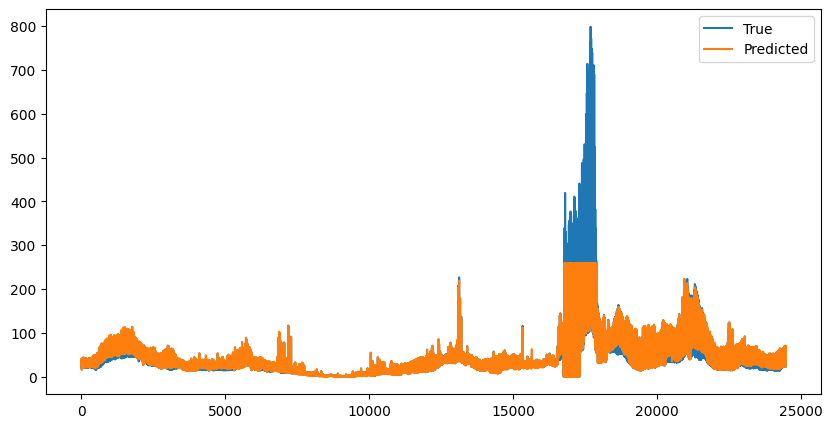

In [112]:
#grid search 이전 파라미터로 모델 학습
input_size = before_gridsearch['input_size']
hidden_size = before_gridsearch['hidden_size']
num_layers = before_gridsearch['num_layers']
output_size = 1
dropout=before_gridsearch['dropout']
lr = before_gridsearch['lr']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = LSTM(input_size, hidden_size, num_layers, output_size,True,0.2)
model = LSTM_original(input_size, hidden_size, num_layers, output_size)
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model.to(device)

num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
# 평가
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')


# 예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(y_test.cpu().numpy(), label='True')
plt.plot(test_outputs.cpu().numpy(), label='Predicted')
plt.legend()
plt.show()


# **grid search 이전 parameter 및 기존 LSTM 사용시**

Total number of high concentration samples: 3580
Number of correctly identified high concentration samples: 3562
Number of high concentration samples missed: 18
Sensitivity (Recall) for high concentration data: 0.9950
Total number of low concentration samples: 20887
Number of correctly identified low concentration samples: 20720
Number of low concentration samples missed: 167
Sensitivity (Recall) for low concentration data: 0.9920


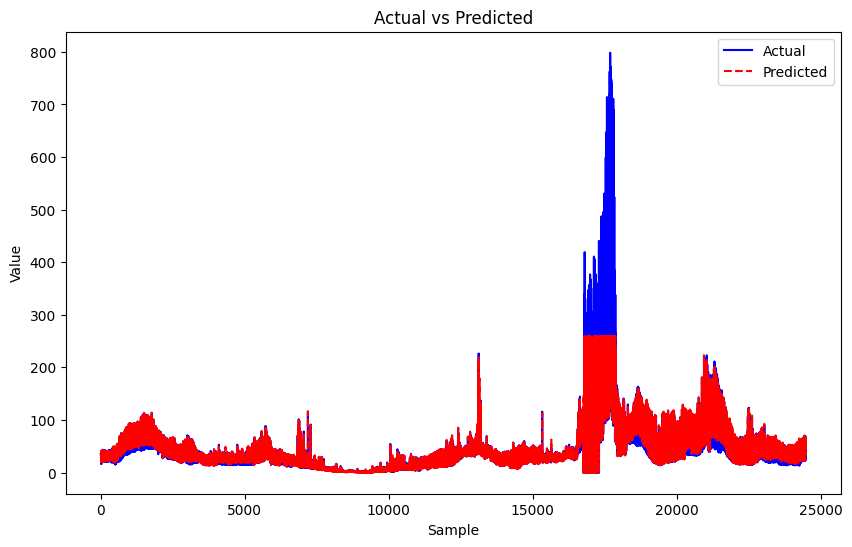

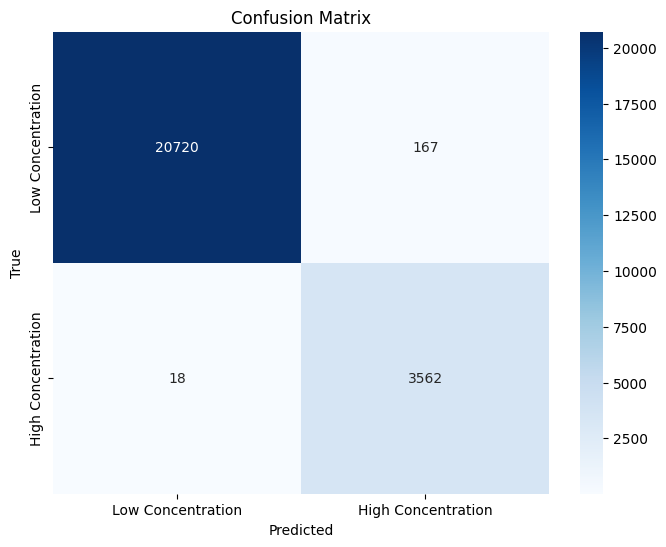

In [113]:
from sklearn.metrics import recall_score, confusion_matrix
import seaborn as sns

model.eval()
with torch.no_grad():
    y_pred = model(X_test.to(device)).cpu().numpy()
    y_pred = y_pred.squeeze()

# 예측값을 고농도와 저농도로 분류 (81을 기준으로 분류)
y_pred_classes = (y_pred >= 81).astype(int)
y_test_classes = (y_test.cpu().squeeze().numpy() >= 81).astype(int)

# 민감도 계산
sensitivity_high = recall_score(y_test_classes, y_pred_classes, pos_label=1)
sensitivity_low = recall_score(y_test_classes, y_pred_classes, pos_label=0)

# 혼동 행렬을 통해 세부 통계 계산
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
tn, fp, fn, tp = conf_matrix.ravel()

# 출력
print(f'Total number of high concentration samples: {tp + fn}')
print(f'Number of correctly identified high concentration samples: {tp}')
print(f'Number of high concentration samples missed: {fn}')
print(f'Sensitivity (Recall) for high concentration data: {sensitivity_high:.4f}')

print(f'Total number of low concentration samples: {tn + fp}')
print(f'Number of correctly identified low concentration samples: {tn}')
print(f'Number of low concentration samples missed: {fp}')
print(f'Sensitivity (Recall) for low concentration data: {sensitivity_low:.4f}')

#loss
plt.figure(figsize=(10, 6))
plt.plot(y_test.cpu().numpy(), label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()

#시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Concentration", "High Concentration"], yticklabels=["Low Concentration", "High Concentration"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [120]:
import torch
from sklearn.model_selection import ParameterGrid
import torch.optim as optim

# LSTM 모델 정의
class LSTM_custom(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTM_custom, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm_cells = nn.ModuleList([nn.LSTMCell(input_size, hidden_size)] +
                                        [nn.LSTMCell(hidden_size, hidden_size) for _ in range(num_layers - 1)])

        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, h_0=None, c_0=None):
        batch_size, seq_length, _ = x.size()

        if h_0 is None:
            h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        if c_0 is None:
            c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        h_t = [h_0[i] for i in range(self.num_layers)]
        c_t = [c_0[i] for i in range(self.num_layers)]

        for t in range(seq_length):
            x_t = x[:, t, :]
            h_t[0], c_t[0] = self.lstm_cells[0](x_t, (h_t[0], c_t[0]))
            for i in range(1, self.num_layers):
                h_t[i], c_t[i] = self.lstm_cells[i](h_t[i-1], (h_t[i], c_t[i]))
                h_t[i] = self.dropout(h_t[i])

        output = self.fc(h_t[-1])
        return output
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, custom, dropout):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.custom = custom
        if custom:
            print("Using custom LSTM model.")
            self.lstm = LSTM_custom(input_size, hidden_size, num_layers, output_size, dropout)
        else:
            print("Using official PyTorch LSTM module.")
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

    def forward(self, x):
        if self.custom:
            outputs = self.lstm(x)
        else:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # device 수정
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # device 수정
            outputs, _ = self.lstm(x, (h0, c0))
            outputs = outputs[:, -1, :]
        return outputs

# 가중치 조정을 위한 손실 함수
class WeightedMSELoss(nn.Module):
    def __init__(self, threshold, weight_large=20.0):
        super(WeightedMSELoss, self).__init__()
        self.threshold = threshold
        self.weight_large = weight_large

    def forward(self, input, target):
        input = input.view(-1)
        target = target.view(-1)
        weights = torch.where(target > self.threshold, self.weight_large, 1.0)
        return (weights * (input - target) ** 2).mean()

In [128]:
best_params_custom = {
    'input_size': X_train.shape[2],
    'hidden_size': 64,
    'num_layers': 5,
    'output_size': 1,
    'dropout': 0.2,
    'use_custom': True,
    'lr': 0.001,
}
threshold = 80
# 가중치 조정을 위한 임계값 (예: 80 이상인 값에 더 큰 가중치 부여)

# **best parameter 및 Custom LSTM 사용**

Using custom LSTM model.
Epoch [1/15], Loss: 500.4678
Epoch [2/15], Loss: 127.7856
Epoch [3/15], Loss: 70.5877
Epoch [4/15], Loss: 45.8372
Epoch [5/15], Loss: 30.9448
Epoch [6/15], Loss: 20.5715
Epoch [7/15], Loss: 15.5123
Epoch [8/15], Loss: 12.1078
Epoch [9/15], Loss: 9.7778
Epoch [10/15], Loss: 8.8897
Epoch [11/15], Loss: 8.0984
Epoch [12/15], Loss: 7.4707
Epoch [13/15], Loss: 7.1681
Epoch [14/15], Loss: 6.9928
Epoch [15/15], Loss: 7.0547
Total number of high concentration samples: 3580
Number of correctly identified high concentration samples: 3560
Number of high concentration samples missed: 20
Sensitivity (Recall) for high concentration data: 0.9944
Total number of low concentration samples: 20887
Number of correctly identified low concentration samples: 20651
Number of low concentration samples missed: 236
Sensitivity (Recall) for low concentration data: 0.9887


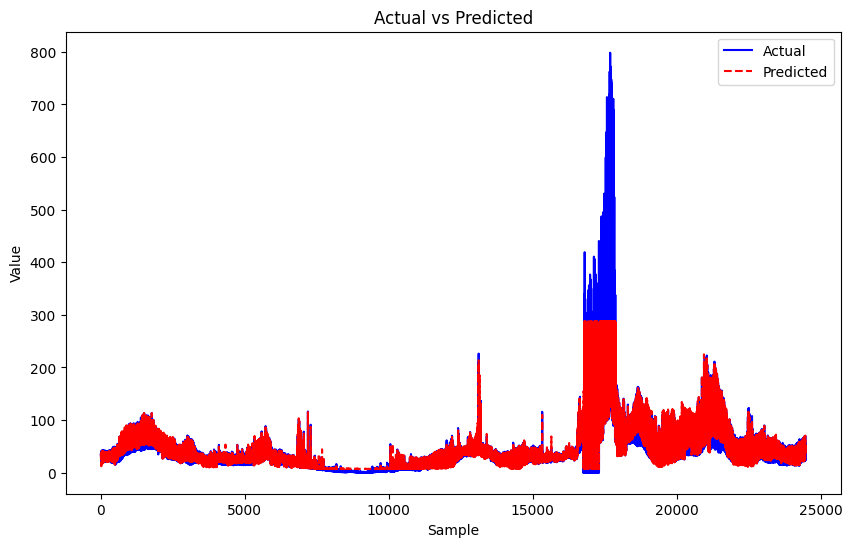

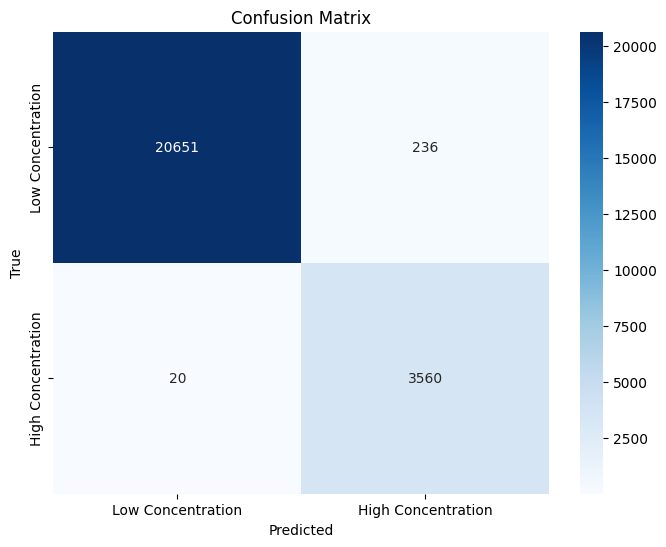

In [122]:
import torch
from sklearn.model_selection import ParameterGrid
import torch.optim as optim
from sklearn.metrics import confusion_matrix, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# 최적 하이퍼파라미터로 모델 학습
input_size = best_params_custom['input_size']
hidden_size = best_params_custom['hidden_size']
num_layers = best_params_custom['num_layers']
output_size = 1
dropout=best_params_custom['dropout']
lr = best_params_custom['lr']

model_1 = LSTM(input_size, hidden_size, num_layers, output_size,True,0.2)
model_1.to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = WeightedMSELoss(threshold,30)
optimizer = optim.Adam(model_1.parameters(), lr=lr, weight_decay=0.01)

model_1.to(device)

num_epochs = 15
for epoch in range(num_epochs):
    model_1.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model_1(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
# 평가
model_1.eval()
with torch.no_grad():
    y_pred = model_1(X_test.to(device)).cpu().numpy()
    y_pred = y_pred.squeeze()


# 예측값을 고농도와 저농도로 분류 (81을 기준으로 분류)
y_pred_classes = (y_pred >= 81).astype(int)
y_test_classes = (y_test.cpu().squeeze().numpy() >= 81).astype(int)

# 민감도 계산
sensitivity_high = recall_score(y_test_classes, y_pred_classes, pos_label=1)
sensitivity_low = recall_score(y_test_classes, y_pred_classes, pos_label=0)

# 혼동 행렬을 통해 세부 통계 계산
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
tn, fp, fn, tp = conf_matrix.ravel()

# 출력
print(f'Total number of high concentration samples: {tp + fn}')
print(f'Number of correctly identified high concentration samples: {tp}')
print(f'Number of high concentration samples missed: {fn}')
print(f'Sensitivity (Recall) for high concentration data: {sensitivity_high:.4f}')

print(f'Total number of low concentration samples: {tn + fp}')
print(f'Number of correctly identified low concentration samples: {tn}')
print(f'Number of low concentration samples missed: {fp}')
print(f'Sensitivity (Recall) for low concentration data: {sensitivity_low:.4f}')

#loss
plt.figure(figsize=(10, 6))
plt.plot(y_test.cpu().numpy(), label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()

#시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Concentration", "High Concentration"], yticklabels=["Low Concentration", "High Concentration"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#**eval.py**

In [129]:
# 데이터 로드 및 전처리 함수 정의
def load_and_preprocess_data(train_path, test_path):
    # 데이터 불러오기
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    # 특성과 타겟 변수 분리 및 전처리
    X_train = train_data.drop(columns=["관측미세먼지", "경과일", "경과시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
    X_test = test_data.drop(columns=["관측미세먼지", "경과일", "경과시간"]).apply(pd.to_numeric, errors='coerce').fillna(0).values
    y_train = train_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values
    y_test = test_data["관측미세먼지"].apply(pd.to_numeric, errors='coerce').fillna(0).values

    # 스탠다드 스케일링
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Tensor로 변환 및 차원 변경
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

    # DataLoader 정의
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    return train_loader, X_test, y_test

# 각 지역의 데이터셋 경로
regions = ["seoul", "ulsan", "incheon", "gwangju", "daejeon", "daegu"]
train_loaders = {}
X_tests = {}
y_tests = {}

for region in regions:
    train_path = f"/content/drive/MyDrive/train_{region}.csv"
    test_path = f"/content/drive/MyDrive/test_{region}.csv"
    train_loader, X_test, y_test = load_and_preprocess_data(train_path, test_path)

    train_loaders[region] = train_loader
    X_tests[region] = X_test
    y_tests[region] = y_test


Using custom LSTM model.
Region: seoul, Epoch [1/10], Loss: 103.4606
Region: seoul, Epoch [2/10], Loss: 17.7601
Region: seoul, Epoch [3/10], Loss: 8.5172
Region: seoul, Epoch [4/10], Loss: 5.5196
Region: seoul, Epoch [5/10], Loss: 4.5814
Region: seoul, Epoch [6/10], Loss: 4.0299
Region: seoul, Epoch [7/10], Loss: 3.9586
Region: seoul, Epoch [8/10], Loss: 3.6972
Region: seoul, Epoch [9/10], Loss: 3.6097
Region: seoul, Epoch [10/10], Loss: 3.4484
Region: seoul
Total number of high concentration samples: 3580
Number of correctly identified high concentration samples: 3579
Number of high concentration samples missed: 1
Sensitivity (Recall) for high concentration data: 0.9997
Total number of low concentration samples: 20887
Number of correctly identified low concentration samples: 20381
Number of low concentration samples missed: 506
Sensitivity (Recall) for low concentration data: 0.9758


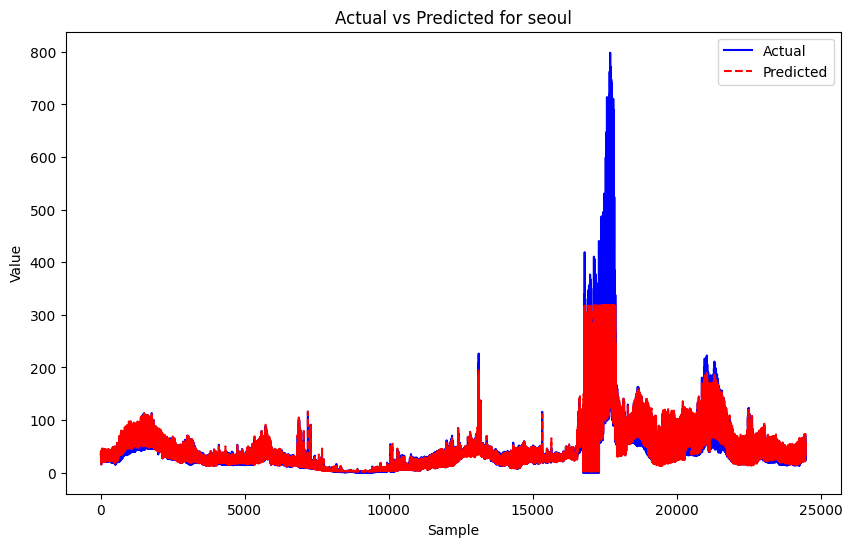

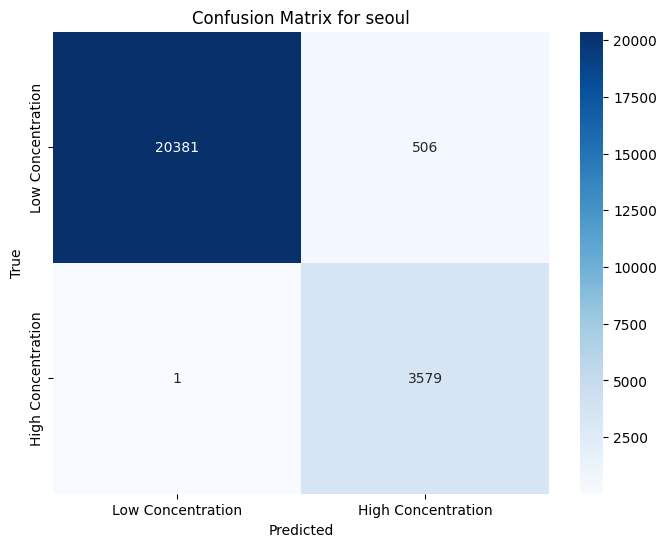

Using custom LSTM model.
Region: ulsan, Epoch [1/10], Loss: 38.2823
Region: ulsan, Epoch [2/10], Loss: 15.7826
Region: ulsan, Epoch [3/10], Loss: 8.1710
Region: ulsan, Epoch [4/10], Loss: 4.7284
Region: ulsan, Epoch [5/10], Loss: 3.0108
Region: ulsan, Epoch [6/10], Loss: 2.6449
Region: ulsan, Epoch [7/10], Loss: 2.3846
Region: ulsan, Epoch [8/10], Loss: 2.2194
Region: ulsan, Epoch [9/10], Loss: 2.0665
Region: ulsan, Epoch [10/10], Loss: 2.0583
Region: ulsan
Total number of high concentration samples: 278
Number of correctly identified high concentration samples: 249
Number of high concentration samples missed: 29
Sensitivity (Recall) for high concentration data: 0.8957
Total number of low concentration samples: 3615
Number of correctly identified low concentration samples: 3607
Number of low concentration samples missed: 8
Sensitivity (Recall) for low concentration data: 0.9978


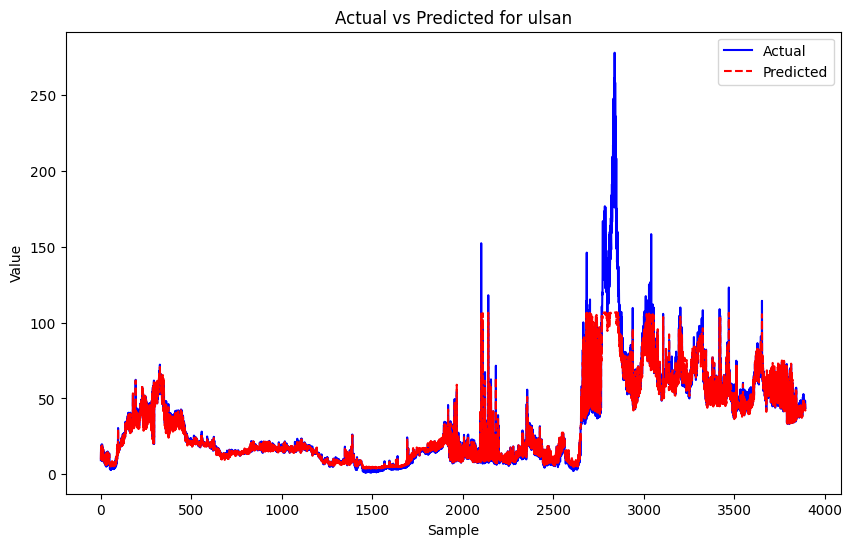

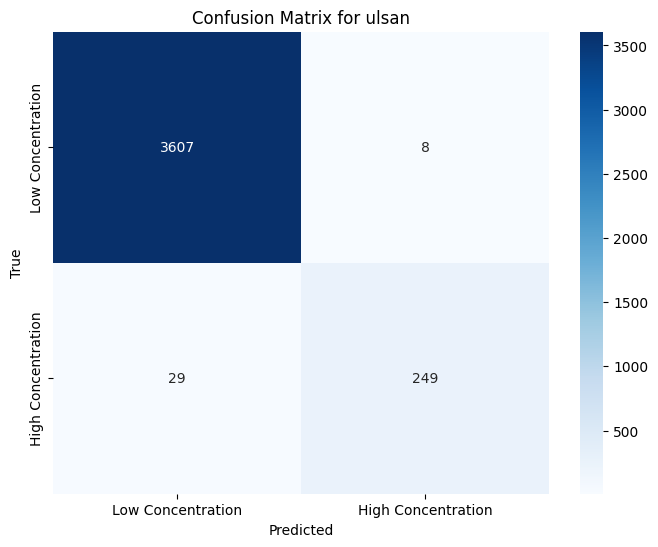

Using custom LSTM model.
Region: incheon, Epoch [1/10], Loss: 177.7779
Region: incheon, Epoch [2/10], Loss: 46.7451
Region: incheon, Epoch [3/10], Loss: 28.1065
Region: incheon, Epoch [4/10], Loss: 20.8060
Region: incheon, Epoch [5/10], Loss: 16.0677
Region: incheon, Epoch [6/10], Loss: 12.3134
Region: incheon, Epoch [7/10], Loss: 9.7723
Region: incheon, Epoch [8/10], Loss: 8.3296
Region: incheon, Epoch [9/10], Loss: 6.9802
Region: incheon, Epoch [10/10], Loss: 5.6729
Region: incheon
Total number of high concentration samples: 750
Number of correctly identified high concentration samples: 743
Number of high concentration samples missed: 7
Sensitivity (Recall) for high concentration data: 0.9907
Total number of low concentration samples: 6771
Number of correctly identified low concentration samples: 6678
Number of low concentration samples missed: 93
Sensitivity (Recall) for low concentration data: 0.9863


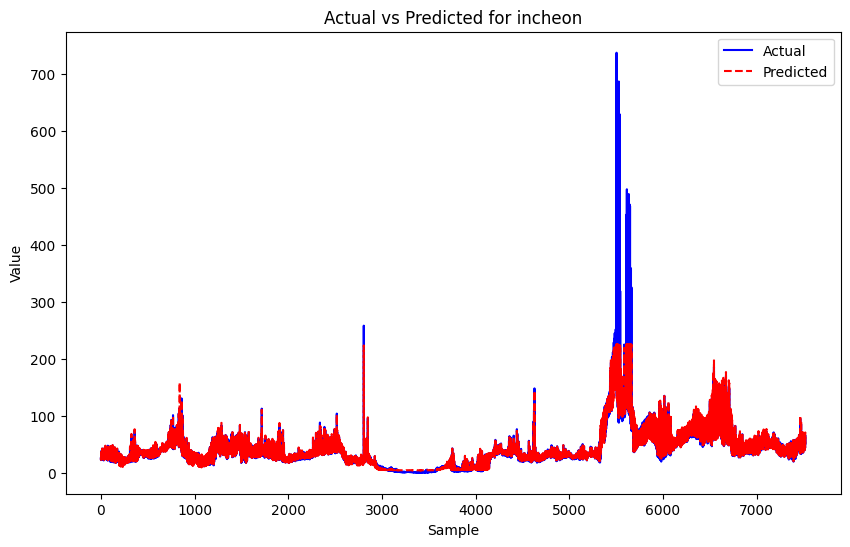

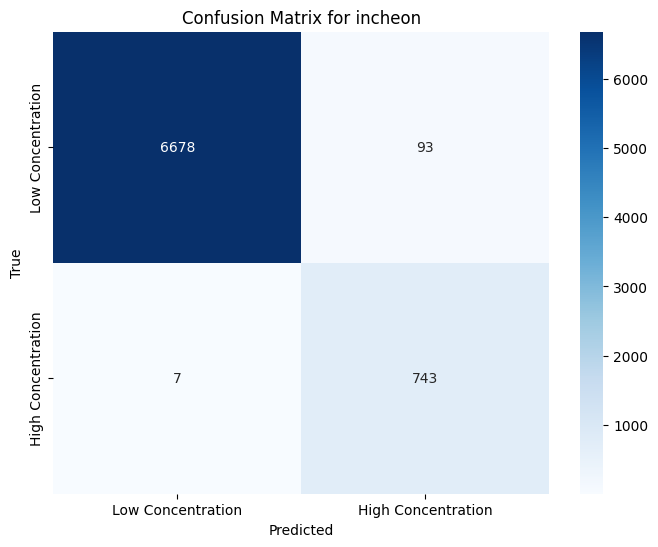

Using custom LSTM model.
Region: gwangju, Epoch [1/10], Loss: 106.7000
Region: gwangju, Epoch [2/10], Loss: 17.7582
Region: gwangju, Epoch [3/10], Loss: 8.6473
Region: gwangju, Epoch [4/10], Loss: 5.5026
Region: gwangju, Epoch [5/10], Loss: 4.3611
Region: gwangju, Epoch [6/10], Loss: 4.0691
Region: gwangju, Epoch [7/10], Loss: 3.9362
Region: gwangju, Epoch [8/10], Loss: 3.6693
Region: gwangju, Epoch [9/10], Loss: 3.5581
Region: gwangju, Epoch [10/10], Loss: 3.4088
Region: gwangju
Total number of high concentration samples: 3580
Number of correctly identified high concentration samples: 3572
Number of high concentration samples missed: 8
Sensitivity (Recall) for high concentration data: 0.9978
Total number of low concentration samples: 20887
Number of correctly identified low concentration samples: 20575
Number of low concentration samples missed: 312
Sensitivity (Recall) for low concentration data: 0.9851


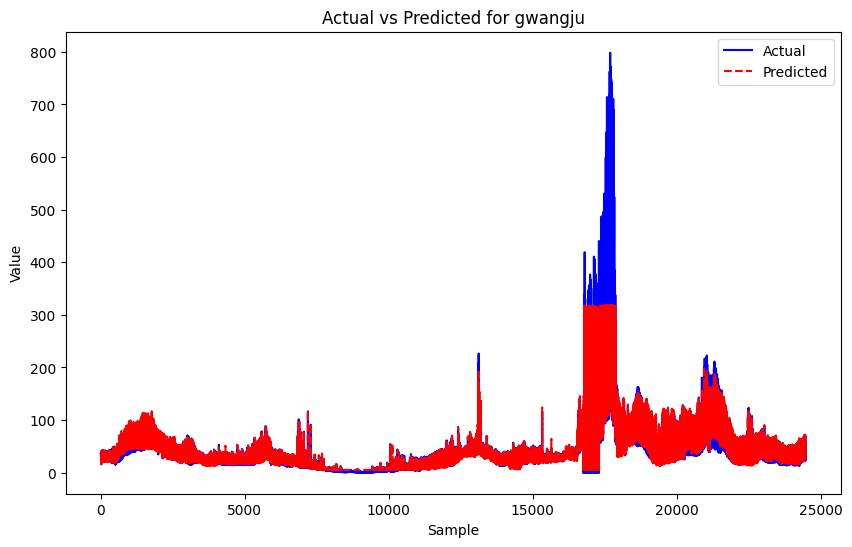

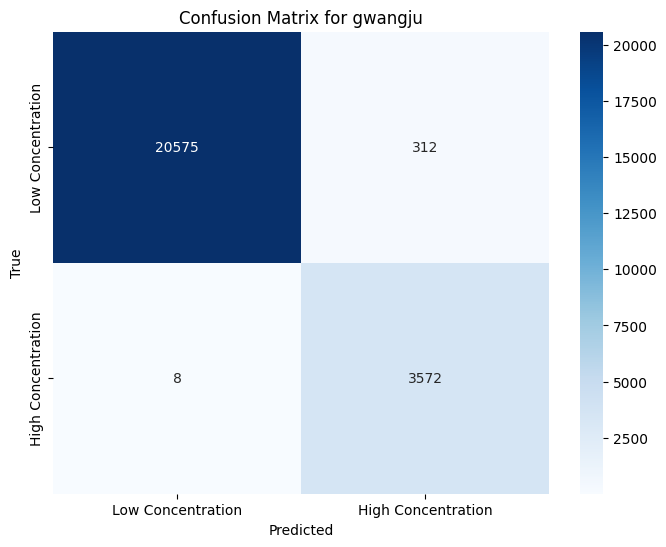

Using custom LSTM model.
Region: daejeon, Epoch [1/10], Loss: 106.8978
Region: daejeon, Epoch [2/10], Loss: 18.1098
Region: daejeon, Epoch [3/10], Loss: 8.7091
Region: daejeon, Epoch [4/10], Loss: 5.7232
Region: daejeon, Epoch [5/10], Loss: 4.5591
Region: daejeon, Epoch [6/10], Loss: 4.0831
Region: daejeon, Epoch [7/10], Loss: 3.8960
Region: daejeon, Epoch [8/10], Loss: 3.8151
Region: daejeon, Epoch [9/10], Loss: 3.7390
Region: daejeon, Epoch [10/10], Loss: 3.5534
Region: daejeon
Total number of high concentration samples: 3580
Number of correctly identified high concentration samples: 3579
Number of high concentration samples missed: 1
Sensitivity (Recall) for high concentration data: 0.9997
Total number of low concentration samples: 20887
Number of correctly identified low concentration samples: 20549
Number of low concentration samples missed: 338
Sensitivity (Recall) for low concentration data: 0.9838


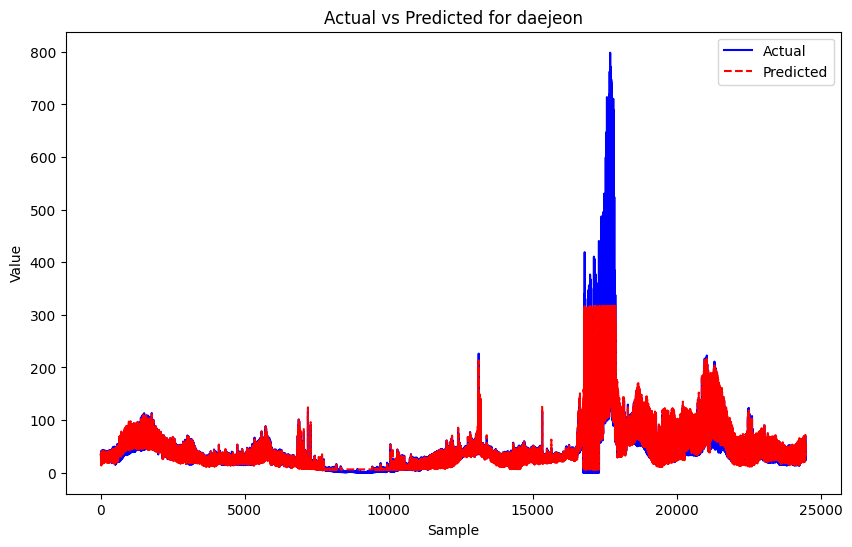

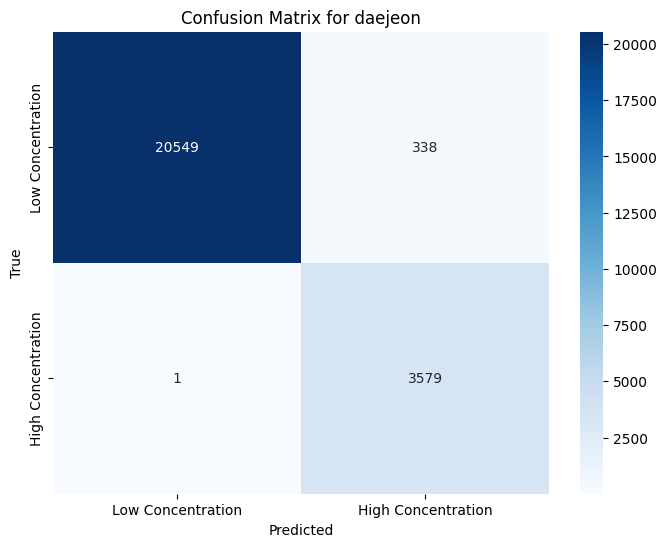

Using custom LSTM model.
Region: daegu, Epoch [1/10], Loss: 99.7497
Region: daegu, Epoch [2/10], Loss: 43.6765
Region: daegu, Epoch [3/10], Loss: 29.0195
Region: daegu, Epoch [4/10], Loss: 23.2067
Region: daegu, Epoch [5/10], Loss: 19.7211
Region: daegu, Epoch [6/10], Loss: 16.4705
Region: daegu, Epoch [7/10], Loss: 14.3381
Region: daegu, Epoch [8/10], Loss: 12.5810
Region: daegu, Epoch [9/10], Loss: 11.2803
Region: daegu, Epoch [10/10], Loss: 10.3660
Region: daegu
Total number of high concentration samples: 728
Number of correctly identified high concentration samples: 724
Number of high concentration samples missed: 4
Sensitivity (Recall) for high concentration data: 0.9945
Total number of low concentration samples: 5759
Number of correctly identified low concentration samples: 5687
Number of low concentration samples missed: 72
Sensitivity (Recall) for low concentration data: 0.9875


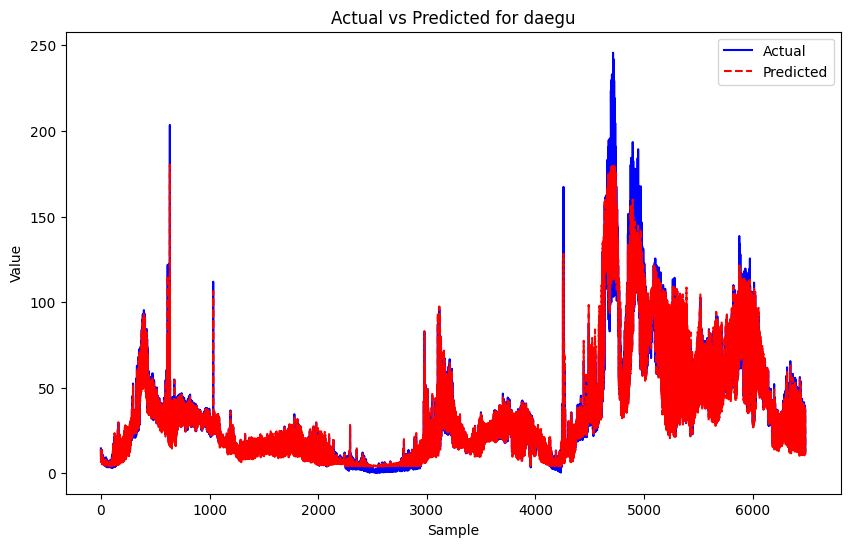

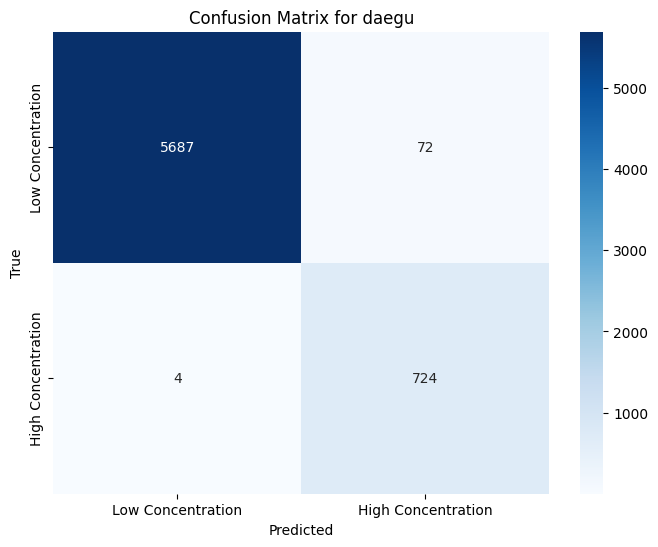

In [134]:
def train_and_evaluate_model(region, train_loader, X_test, y_test, num_epochs=10):
    model_1 = LSTM(
        input_size=X_test.shape[2],
        hidden_size=best_params_custom['hidden_size'],
        num_layers=best_params_custom['num_layers'],
        output_size=1,
        custom=best_params_custom['use_custom'],
        dropout=best_params_custom['dropout']
    ).to(device)
    criterion = WeightedMSELoss(threshold,20)
    optimizer = optim.Adam(model_1.parameters(), lr=0.001, weight_decay=0.01)

    for epoch in range(num_epochs):
        model_1.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_1(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Region: {region}, Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    model_1.eval()
    with torch.no_grad():
        y_pred = model_1(X_test.to(device)).cpu().numpy()
        y_pred = y_pred.squeeze()

    y_pred_classes = (y_pred >= 81).astype(int)
    y_test_classes = (y_test.cpu().squeeze().numpy() >= 81).astype(int)

    sensitivity_high = recall_score(y_test_classes, y_pred_classes, pos_label=1)
    sensitivity_low = recall_score(y_test_classes, y_pred_classes, pos_label=0)

    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
    tn, fp, fn, tp = conf_matrix.ravel()

    print(f'Region: {region}')
    print(f'Total number of high concentration samples: {tp + fn}')
    print(f'Number of correctly identified high concentration samples: {tp}')
    print(f'Number of high concentration samples missed: {fn}')
    print(f'Sensitivity (Recall) for high concentration data: {sensitivity_high:.4f}')
    print(f'Total number of low concentration samples: {tn + fp}')
    print(f'Number of correctly identified low concentration samples: {tn}')
    print(f'Number of low concentration samples missed: {fp}')
    print(f'Sensitivity (Recall) for low concentration data: {sensitivity_low:.4f}')

    plt.figure(figsize=(10, 6))
    plt.plot(y_test.squeeze().cpu(), label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted for {region}')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Concentration", "High Concentration"], yticklabels=["Low Concentration", "High Concentration"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix for {region}")
    plt.show()

regions = ["seoul", "ulsan", "incheon", "gwangju", "daejeon", "daegu"]

for region in regions:
    train_path = f"/content/drive/MyDrive/train_{region}.csv"
    test_path = f"/content/drive/MyDrive/test_{region}.csv"
    train_loader, X_test, y_test = load_and_preprocess_data(train_path, test_path)
    train_and_evaluate_model(region, train_loader, X_test, y_test)

In [ ]:
def train_and_evaluate_model(region, train_loader, X_test, y_test, best_params, num_epochs=10):
    model = LSTM_original(
        input_size=X_test.shape[2],
        hidden_size=before_gridsearch['hidden_size'],
        num_layers=before_gridsearch['num_layers'],
        output_size=1,
    ).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Region: {region}, Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test.to(device)).cpu().numpy()
        y_pred = y_pred.squeeze()

    y_pred_classes = (y_pred >= 81).astype(int)
    y_test_classes = (y_test.cpu().squeeze().numpy() >= 81).astype(int)

    sensitivity_high = recall_score(y_test_classes, y_pred_classes, pos_label=1)
    sensitivity_low = recall_score(y_test_classes, y_pred_classes, pos_label=0)

    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
    tn, fp, fn, tp = conf_matrix.ravel()

    print(f'Region: {region}')
    print(f'Total number of high concentration samples: {tp + fn}')
    print(f'Number of correctly identified high concentration samples: {tp}')
    print(f'Number of high concentration samples missed: {fn}')
    print(f'Sensitivity (Recall) for high concentration data: {sensitivity_high:.4f}')
    print(f'Total number of low concentration samples: {tn + fp}')
    print(f'Number of correctly identified low concentration samples: {tn}')
    print(f'Number of low concentration samples missed: {fp}')
    print(f'Sensitivity (Recall) for low concentration data: {sensitivity_low:.4f}')

    plt.figure(figsize=(10, 6))
    plt.plot(y_test.squeeze().cpu(), label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted for {region}')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Concentration", "High Concentration"], yticklabels=["Low Concentration", "High Concentration"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix for {region}")
    plt.show()

regions = ["seoul", "ulsan", "incheon", "gwangju", "daejeon", "daegu"]

for region in regions:
    train_path = f"/content/drive/MyDrive/train_{region}.csv"
    test_path = f"/content/drive/MyDrive/test_{region}.csv"
    train_loader, X_test, y_test = load_and_preprocess_data(train_path, test_path)
    train_and_evaluate_model(region, train_loader, X_test, y_test, before_gridsearch)